## Disease detection with uncertainty about prediction

This notebook illustrates how to use the Bayesian CNN models presented in our [paper](https://www.biorxiv.org/content/early/2017/10/18/084210.article-metrics).

In [1]:
from BCNN import BCNN
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Exemplary fundus image

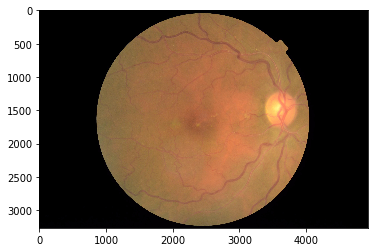

In [2]:
plt.imshow(plt.imread('data/example.jpeg'))

#### Crop, resize and enhance colour contrast

In [3]:
!python preprocess_images.py data data/processed

Preprocessing initiated.
  Source: data
  Target: data/processed
Assigning batch 1/1
Preprocessing complete.


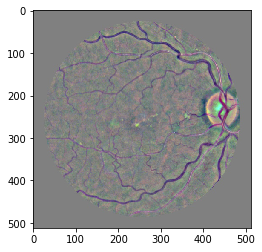

In [4]:
plt.imshow(plt.imread('data/processed/example.jpeg'))

#### Create a dataset object for image access by the networks

In [5]:
# dataset = datasets.DatasetFromDirectory(path_data='data/processed', ext='.jpeg',
#                                         preprocessing=datasets.KaggleDR.standard_normalize)

In [6]:
# x = dataset.prepare_image(dataset.load_image('example'))[None, :]

In [7]:
x = plt.imread('data/processed/example.jpeg')

In [8]:
def standard_normalize(image):
    """Normalize image to have zero mean and unit variance.
    Subtracts channel MEAN and divides by channel STD
    """
    # channel standard deviations (calculated by team o_O)
    STD = np.array([70.53946096, 51.71475228, 43.03428563])
    # channel means (calculated by team o_O)
    MEAN = np.array([108.64628601, 75.86886597, 54.34005737])

    return np.divide(np.subtract(image,
                                 MEAN[np.newaxis, np.newaxis, :]),
                     STD[np.newaxis, np.newaxis, :])

In [9]:
x = standard_normalize(x)

In [10]:
# preprocess for keras
x = x.reshape((-1,) + x.shape)

### Detection of mild or more severe diabetic retinopathy

In [11]:
bcnn1 = BCNN(p_conv=0.2, last_layer='layer_17', 
             weights='models/weights_bcnn1_392bea6.h5', n_classes=2,
            )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
bcnn1.predict(x)

array([[0.6457774 , 0.35422257]], dtype=float32)

In [13]:
HEALTHY, DISEASED = 0, 1

#### Bayesian prediction with uncertainty

In [14]:
mc_samples = bcnn1.mc_samples(x, T=100)[0, :] # take the 0'th data sample because we have only one image

##### For both the healthy and diseased output units we have hundred predictions, i.e. Monte Carlo samples, each

In [15]:
mc_samples.shape

(2, 100)

##### The MC samples can be used to approximate the predictive distribution

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Predictive posterior ($\\mu_{pred}=0.67$;$\\sigma_{pred}=0.10$)')

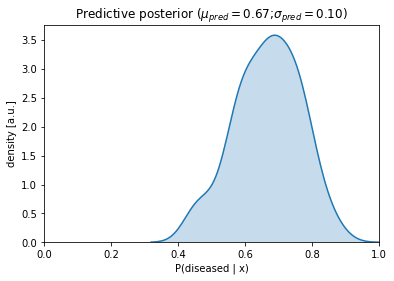

In [16]:
mu_pred = mc_samples[DISEASED, :].mean()
std_pred = mc_samples[DISEASED, :].std()

sns.kdeplot(mc_samples[DISEASED, :], shade=True)
plt.xlim(0, 1)
plt.xlabel('P(diseased | x)')
plt.ylabel('density [a.u.]')
plt.title('Predictive posterior ($\mu_{pred}=%.2f$;$\sigma_{pred}=%.2f$)' % (mu_pred, std_pred))

### Detection of moderate or more severe diabetic retinopathy just requires to change the model...

In [17]:
bcnn2 = BCNN(p_conv=0.2, last_layer='layer_17', weights='models/weights_bcnn2_b69aadd.h5', n_classes=2)

In [18]:
mc_samples = bcnn2.mc_samples(x, T=100)[0, :] # take the 0'th data sample because we have only one image

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Predictive posterior ($\\mu_{pred}=0.80$;$\\sigma_{pred}=0.09$)')

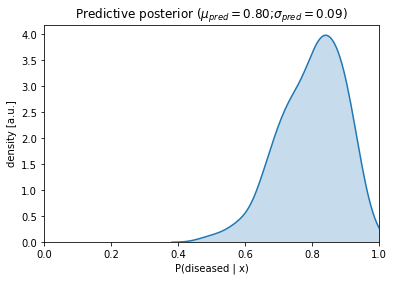

In [19]:
mu_pred = mc_samples[DISEASED, :].mean()
std_pred = mc_samples[DISEASED, :].std()

sns.kdeplot(mc_samples[DISEASED, :], shade=True)
plt.xlim(0, 1)
plt.xlabel('P(diseased | x)')
plt.ylabel('density [a.u.]')
plt.title('Predictive posterior ($\mu_{pred}=%.2f$;$\sigma_{pred}=%.2f$)' % (mu_pred, std_pred))